# 4.1.3 建筑风格模型的评价
方法同[4.1.3-建筑年代模型评价3.ipynb](../../4.1-对建筑年代进行深度学习训练和预测/4.1.3-建筑年代模型评价3.ipynb)

## 一、对测试集进行预测
测试集：模型训练中因为我们固定随机种子`manual_seed(2)`，所以我们现在取出当时分割之后的占比20%的测试集：`test_data_raw`，我们的模型是没有拿测试集的数据进行训练的。

### 1.读取图片文件并分割出测试集数据

In [1]:
# 重新加载
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Dataset

img_root =  '../../data/output/剑桥建筑风格训练集图片/cambridge' 
all_data = datasets.ImageFolder(root=img_root)  # 不要应用tranform
# 拆分数据
train_size = int(0.8 * len(all_data))
test_size = len(all_data) - train_size
# 固定随机种子
torch.manual_seed(2)
train_data_raw, test_data_raw = random_split(all_data, [train_size, test_size])

In [2]:
len(test_data_raw)

5051

### 2.获取类名列表

In [3]:
class_names = all_data.classes

# 数据集的类别的字典形式
class_dict = all_data.class_to_idx
print(class_dict)

{'18th-century_style': 0, 'contemporary': 1, 'early_19th-century_style': 2, 'interwar': 3, 'late_19th-century_style': 4, 'postwar': 5, 'revival': 6}


### 3.自定义加载dataset并加载

我们需要进一步修改CustomDataset类以返回文件名中的建筑id。然后，在预测循环中收集文件名，并在所有预测完成后将它们与预测结果一起保存到CSV文件中。以下是如何实现它的步骤：

In [16]:
import os
class CustomDataset(Dataset):
    """包装PyTorch数据集以应用转换。"""
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        self.imgs = subset.dataset.imgs

    def __getitem__(self, index):
        img, y = self.subset[index] # 这里的y是类别的索引
        
        # 获取文件名
        file_name = self.imgs[self.subset.indices[index]][0]  # 修改这里以匹配您的文件名和路径结构
        # 获取文件名中的id 修改此处以匹配您的文件名和路径结构
        id = os.path.basename(file_name).split("_")[0] 
        
        if self.transform:
            img = self.transform(img)

        return img, y, id

    def __len__(self):
        return len(self.subset)

### 4.定义transform并加载测试集

In [17]:
# 只需要调整尺寸和转换为张量
test_transform = transforms.Compose([
        transforms.Resize(size=(300, 300), antialias=True), 
        transforms.ToTensor()
        
    ])

In [18]:
test_data = CustomDataset(test_data_raw, transform=test_transform)

In [19]:
#### 测试能不能获取id
# 获取数据集中的前几个项
for i in range(5):  # 例如，检查前5项
    img, y, id = test_data[i]
    print(f"Item {i}:")
    print(f"    ID: {id}")
    print(f"    Label: {y}")
    # 如果图片是一个张量，您可以打印其形状
    print(f"    Image shape: {img.shape if hasattr(img, 'shape') else 'not a tensor'}")
    print("\n")

Item 0:
    ID: 0001000010019320
    Label: 4
    Image shape: torch.Size([3, 300, 300])


Item 1:
    ID: 0001000010136610
    Label: 3
    Image shape: torch.Size([3, 300, 300])


Item 2:
    ID: 0001000010145714
    Label: 3
    Image shape: torch.Size([3, 300, 300])


Item 3:
    ID: 0001000010178287
    Label: 5
    Image shape: torch.Size([3, 300, 300])


Item 4:
    ID: 0001000010062150
    Label: 4
    Image shape: torch.Size([3, 300, 300])


### 5.加载模型

In [21]:
from torchvision.models import densenet121
from torchvision.models.densenet import DenseNet121_Weights
import torch
import torch.nn as nn

device = "cuda" if torch.cuda.is_available() else "cpu"

# 加载预训练的DenseNet121模型
model = densenet121(weights=DenseNet121_Weights.DEFAULT)

## 修改最后一层的输出特征数
num_features = model.classifier.in_features
# 修改为9个类别的输出特征数
model.classifier = nn.Linear(num_features, 7)


# 加载建筑年代的数据集
model_path = '../models/building_style_weights_2/model_epoch_32.pth'
model.load_state_dict(torch.load(model_path, map_location=device))

# 调整到eval评估模式
model.eval()

model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [22]:
# 创建DataLoader 我在云端跑的4090跑的 BATCH_SIZE = 704，num_workers=12比较合适
BATCH_SIZE = 64 # 704 

test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=0) #  num_workers=0 代表不使用多进程 在notebook中需要设为0以避免错误
len(test_loader)

79

### 6.进行预测

In [23]:
# 存储真实标签 预测标签 文件名
true_labels = []
pred_labels = []
ids_list = []

In [24]:
from tqdm import tqdm # 用来显示进度条

with torch.inference_mode():
    for images, labels, id in tqdm(test_loader, desc="Predicting"): # 遍历test_loader会使用__getitem__方法,返回img, y, id
        
        # 将数据移动到GPU上（如果可用）
        images, labels = images.to(device), labels.to(device)

        # 运行模型以获取预测（向前传递）
        outputs = model(images)

        # 使用argmax获取最大值的索引
        test_pred_labels = outputs.argmax(dim=1)
        
        # 将预测标签、真实标签和建筑id添加到列表中
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(test_pred_labels.cpu().numpy())
        ids_list.extend(id)
        
    # 如果您想查看这一批的结果，可以打印或处理这些列表
    # print("真实标签", true_labels)
    # print("预测标签:", pred_labels)
    # print("建筑id", ids_list)

Predicting: 100%|██████████| 79/79 [05:55<00:00,  4.50s/it]


### 7保存预测结果

In [25]:
import pandas as pd

# 创建一个数据框来保存文件名和预测
df_predictions = pd.DataFrame({
    'id': ids_list,
    'prediction': pred_labels,  # 这是之前收集的预测列表
    'true_label': true_labels  # 这是之前收集的真实标签列表
})

# 将数据框写入CSV文件
df_predictions.to_csv('predictions_with_building_style_model_2_on_test_data.csv', index=False)

### 8.可视化预测结果
#### 8.1直接matplotlib用绘制结果

In [26]:
# 从 DataLoader 中抽取第一批数据

BATCH_SIZE = 8

test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)  # 当您在使用 DataLoader 时设置 num_workers 大于 0 以使用多个子进程加载数据时，PyTorch 使用 multiprocessing 来创建这些子进程。但是，multiprocessing 需要能够从主进程中找到并加载任何自定义函数或类，这在 Jupyter Notebook 或其他交互式环境中可能会出问题。

if __name__ == '__main__': # 以尝试将启动训练过程的代码放入此保护块中。这有助于防止 multiprocessing 在它不应该这样做的时候启动新进程。
    test_data_iter = iter(test_loader)
    test_samples, test_labels, ids = next(test_data_iter) # next() 函数是用来获取迭代器的下一个批次的数据
    print(test_samples.shape, test_labels.shape, len(ids) )


torch.Size([8, 3, 300, 300]) torch.Size([8]) 8


test_samples是8个512*512的rgb图像，test_labels是8个一维数组代表真实标签，ids_list是自定义dataset返回的列表，此时返回包含8个建筑id的列表，我们也可在自定义datasets中设置为一维数组。

In [27]:
# print(test_samples, test_labels, ids) # 可以打印具体结果

#### 同样的方法进行预测，但是这次我们要绘制图片

In [28]:
class_dict

{'18th-century_style': 0,
 'contemporary': 1,
 'early_19th-century_style': 2,
 'interwar': 3,
 'late_19th-century_style': 4,
 'postwar': 5,
 'revival': 6}

In [29]:
# 创建一个值到键的反向映射
reverse_dict = {value: key for key, value in class_dict.items()}
reverse_dict

{0: '18th-century_style',
 1: 'contemporary',
 2: 'early_19th-century_style',
 3: 'interwar',
 4: 'late_19th-century_style',
 5: 'postwar',
 6: 'revival'}

In [30]:
# 通过反向映射，我们可以直接用值获取键
key_with_value = reverse_dict[0]
key_with_value

'18th-century_style'

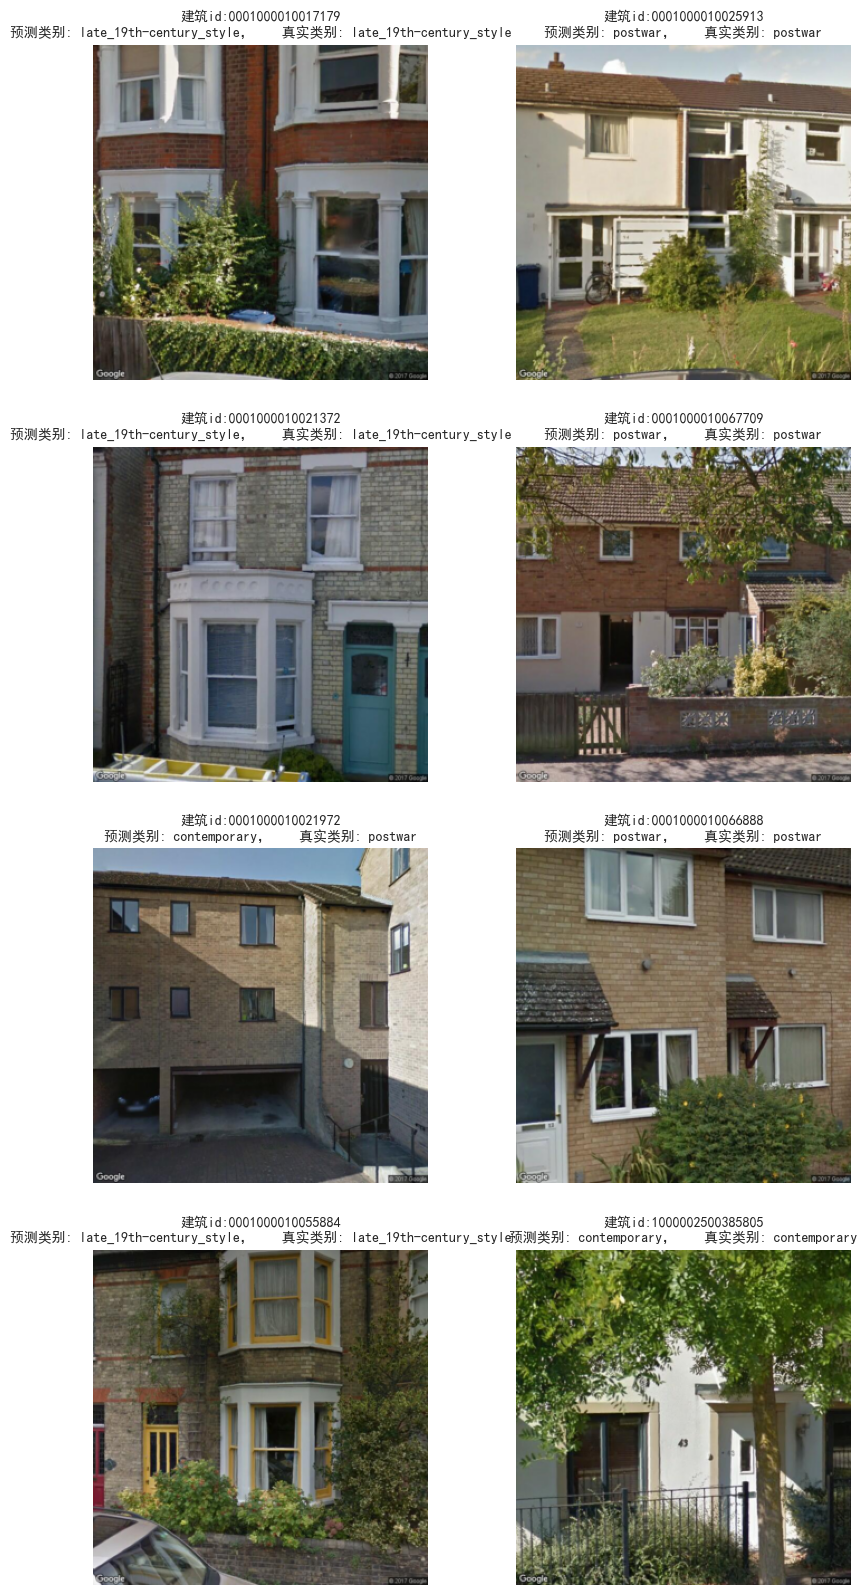

In [31]:
from tqdm import tqdm 
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import numpy as np
# 存储真实标签 预测标签 文件名
true_labels = []
pred_labels = []
ids_list = []

images_so_far = 0
fig = plt.figure(figsize=(10, 20))
font = FontProperties(fname=r"C:\Windows\Fonts\simhei.ttf", size=10)
num_images = 8

# # 可以继续调用获取第二批数据
next_samples, next_labels, ids = next(test_data_iter)
    
with torch.inference_mode():

        
        # 将数据移动到GPU上（如果可用）
        images, labels = next_samples.to(device), next_labels.to(device)

        # 运行模型以获取预测（向前传递）
        outputs = model(images)

        # 使用argmax获取最大值的索引
        test_pred_labels = outputs.argmax(dim=1)
        
        # 选择要显示的图片
        for j in range(images.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            pred_label = reverse_dict.get(int(test_pred_labels[j]))
            true_label = reverse_dict.get(int(labels[j]))
            ax.set_title(f'建筑id:{ids[j]}\n预测类别: {pred_label}，    真实类别: {true_label}', fontproperties=font)
            
            # 将图形转移到cpu 并且更改通道顺序 从[3, 512, 512]更改为[512, 512, 3]
            image = images.cpu().data[j].numpy().transpose((1, 2, 0))

            plt.imshow(image)    

#### 8.2 利用注意力机制查看模型关注哪些方面
观察模型观察的是建筑的哪一个部分，有助于了解不同建筑年代的建筑局部的差异点在哪？是建筑外墙的材料？门或窗的形式？我们可以使用一种叫计算机视觉中的类激活映射（Class Activation Mapping，简称 CAM）技术的方法。

类激活映射（Class Activation Mapping，简称 CAM）是一种在计算机视觉中广泛使用的技术，特别是在深度学习和卷积神经网络（CNN）的上下文中。它用于可视化输入图像的哪些部分被模型用来识别特定的类别。换句话说，CAM帮助我们理解模型的决策过程，特别是模型是如何从视觉信息中“学习”并做出分类决策的。

![image.png](attachment:d2b966e5-df64-4abf-9641-242e304003a1.png)![image.png](attachment:88b8cc69-76f1-4534-99f9-433ce718c7d3.png)

我们可以自己“手搓”一个CAM，也可以直接用别人的开源项目，我在Github发现了两个高星CAM开源项目：[frgfm/orch-cam](https://github.com/frgfm/torch-cam)和[zhoubolei/CAM](https://github.com/zhoubolei/CAM)。
在分析这两个库的结构时，我们可以注意到一些关键差异。首先，我们来看看每个库的主要组成部分。

"frgfm/torch-cam" 主要是一个为 PyTorch 用户设计的库，提供了一个模块化和易于集成的 CAM 解决方案。而 "zhoubolei/CAM" 则更像是一个完整的研究项目，包含了从理论解释到实际应用的所有内容，使用的是 MATLAB 和 Caffe 框架，并提供了多种预训练模型。

1. frgfm/torch-cam -，它是一个针对 PyTorch 的类激活映射（CAM）实现。观察项目之后发现有以下特点：

    - 模块化设计：代码使用面向对象的方法，定义了一个基础类 _CAM，用于实现类激活映射（CAM）的核心功能。这种设计允许扩展不同类型的 CAM 方法。

    - 钩子机制：使用 PyTorch 的钩子（hook）功能来捕获目标层的输出。这对于获取模型内部层的激活特征非常有用。

    - 灵活的目标层选择：用户可以指定目标层，或者让系统自动选择。这为不同的应用场景提供了灵活性。

    - 正则化和ReLU：提供了选项来正则化CAM结果，并在必要时应用ReLU函数。

    - 支持多层CAM融合：如果用户从多个层获取CAM，该库提供了方法来融合这些映射。

    **这个库是为PyTorch框架设计的，它提供了一个高度模块化和可定制的系统，可以轻松地与现有的PyTorch模型集成。如果您已经在使用PyTorch并且需要一个能够快速集成并且具有良好文档支持的解决方案，那么这个库可能是最佳选择。**

2. zhoubolei/CAM - 这个库包含了多种文件和脚本，看起来更像是一个项目或研究的代码库。

    - 研究项目：这个库是基于作者发表在 CVPR'16 上的论文。它不仅提供了代码实现，还解释了类激活映射（CAM）的理论基础。

    - 多种模型支持：库中包含了多种预训练的 CAM 模型，如 GoogLeNet-CAM、VGG16-CAM 等，并提供了相应的权重文件。

    - 使用指南：README 文件提供了详细的指导，说明了如何安装依赖项、下载预训练模型并运行示例代码来生成热图。

    - 多种实现：除了主要的 MATLAB 实现外，还提到了其他语言的实现，如 PyTorch 和 TensorFlow。

    - 评估脚本：库中包含了用于评估模型性能的脚本，特别是在 ILSVRC 数据集上。

    这个库提供了一个更全面的解决方案，包括预训练模型、详细的使用说明和评估脚本。它更多地侧重于教育和研究，提供了对CAM理论的深入理解。但是，它主要基于MATLAB和Caffe，然而我不熟悉这些工具。

#### 我们使用"frgfm/torch-cam"来实现CAM
##### STEP1:安装：
您可以使用pypi安装软件包的最新稳定版本，如下所示：

`pip install torchcam`

或使用conda：

`conda install -c frgfm torchcam`


In [34]:
# 设置CAM
# step:1使用上文定义的模型并且设置为评估模式
from torchvision.models import densenet121
from torchvision.models.densenet import DenseNet121_Weights
import torch
import torch.nn as nn

device = "cuda" if torch.cuda.is_available() else "cpu"

# 加载预训练的DenseNet121模型
model = densenet121(weights=DenseNet121_Weights.DEFAULT)

## 修改最后一层的输出特征数
num_features = model.classifier.in_features
# 修改为9个类别的输出特征数
model.classifier = nn.Linear(num_features, 7)


# 加载建筑年代的数据集
model_path = '../models/building_style_weights_2/model_epoch_32.pth'
model.load_state_dict(torch.load(model_path, map_location=device))

# 调整到eval评估模式
model.eval()

model.to(device)

from torchinfo import summary
summary(model=model, 
        input_size=(32, 3, 300, 300), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 


Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
DenseNet (DenseNet)                           [32, 3, 300, 300]    [32, 7]              --                   True
├─Sequential (features)                       [32, 3, 300, 300]    [32, 1024, 9, 9]     --                   True
│    └─Conv2d (conv0)                         [32, 3, 300, 300]    [32, 64, 150, 150]   9,408                True
│    └─BatchNorm2d (norm0)                    [32, 64, 150, 150]   [32, 64, 150, 150]   128                  True
│    └─ReLU (relu0)                           [32, 64, 150, 150]   [32, 64, 150, 150]   --                   --
│    └─MaxPool2d (pool0)                      [32, 64, 150, 150]   [32, 64, 75, 75]     --                   --
│    └─_DenseBlock (denseblock1)              [32, 64, 75, 75]     [32, 256, 75, 75]    --                   True
│    │    └─_DenseLayer (denselayer1)         [32, 64, 75, 75]     [32, 32, 75, 75]    

在使用类激活映射（CAM）的情况下，通常会选择网络中的最后一个卷积层或与最后一个卷积层紧密相关的层作为目标层。这是因为这些层通常包含关于目标类的空间信息，这对于理解网络如何“看到”和识别特定特征是非常有用的。

在我们提供的 DenseNet 模型中，应该将目标层指定为最后一个 _DenseBlock 或其内部的最后一个 _DenseLayer。具体来说，这可能是 "denseblock4" 或 "denseblock4" 中的最后一个 "denselayer"（例如 "denselayer16"）。这些层在空间分辨率上保留了足够的信息，同时包含了对模型决策至关重要的特征表示。

In [35]:
# 查看模型所有层的名称
for name, module in model.named_children():
    print(name)

features
classifier


在PyTorch中，如果想要进一步探索嵌套在另一个模块中的层（例如，在features模块中），则需要进行递归遍历。以下是如何获取features模块中各层的名称：

In [36]:
def print_layers(module, parent_name=''):
    # 遍历当前模块中的所有子模块
    for name, sub_module in module.named_children():
        # 构造子模块的名称
        layer_name = f"{parent_name}.{name}" if parent_name else name

        # 打印子模块的名称
        print(layer_name)

        # 递归调用以遍历更深层的子模块
        print_layers(sub_module, parent_name=layer_name)

# 获取模型的 'features' 子模块
features = model.features

# 打印 'features' 子模块中的所有层的名称
# print_layers(features)

In [37]:
# Set your CAM extractor
from torchcam.methods import SmoothGradCAMpp
cam_extractor = SmoothGradCAMpp(model, target_layer='features.denseblock4') # 默认情况下，检索CAM的层被设置为最后一个非简化卷积层。如果您希望研究特定的层，请在构造函数中使用 target_layer 参数。

In [38]:
from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image

img = read_image(r"../../data/output/剑桥建筑风格训练集图片/cambridge/contemporary/0001000009971219_K5Unjv5ap5VzOJ3491JZPg.jpg")
img.shape

torch.Size([3, 640, 640])

In [39]:
# # 移除png的alpha通道
# img = img[:3, :, :]
# img.shape

torch.Size([3, 640, 640])

In [40]:
# Preprocess it for your chosen model
input_tensor = normalize(resize(img, (300, 300)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
input_tensor.shape

C:\Users\hncdj\anaconda3\envs\dl\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([3, 300, 300])

In [41]:
with SmoothGradCAMpp(model, target_layer='features.denseblock4') as cam_extractor:
    
    input_tensor = input_tensor.to(device)
    
    # Preprocess your data and feed it to the model
    out = model(input_tensor.unsqueeze(0))
    # Retrieve the CAM by passing the class index and the model output
    activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)
activation_map

[tensor([[[0.0000, 0.1437, 0.2005, 0.1751, 0.2118, 0.3827, 0.4782, 0.4774,
           0.1850],
          [0.2472, 0.5037, 0.6449, 0.5309, 0.5354, 0.6713, 0.8019, 0.8150,
           0.4354],
          [0.4328, 0.7733, 0.9034, 0.6828, 0.6001, 0.6583, 0.7789, 0.8990,
           0.5340],
          [0.5031, 0.8750, 0.9819, 0.7063, 0.6110, 0.5922, 0.7420, 0.8980,
           0.6097],
          [0.5646, 0.9078, 0.8929, 0.6875, 0.6999, 0.7013, 0.8326, 0.9439,
           0.6546],
          [0.5057, 0.8072, 0.7481, 0.6737, 0.7952, 0.8502, 0.9637, 1.0000,
           0.6582],
          [0.4711, 0.7288, 0.6333, 0.6165, 0.7596, 0.8188, 0.8464, 0.8559,
           0.5380],
          [0.4383, 0.7262, 0.6065, 0.5671, 0.6104, 0.6758, 0.6542, 0.7195,
           0.4232],
          [0.2518, 0.4355, 0.3295, 0.2967, 0.2674, 0.2724, 0.2500, 0.3180,
           0.1631]]], device='cuda:0')]

In [42]:
activation_map[0].shape

torch.Size([1, 9, 9])

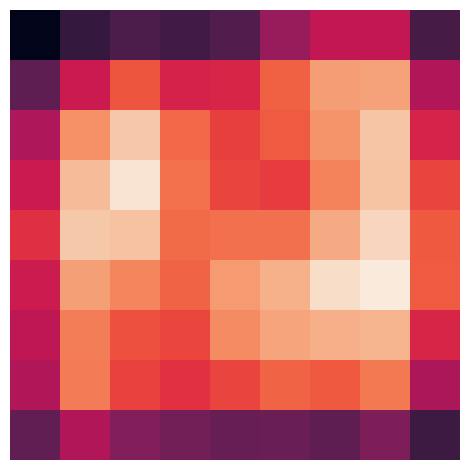

In [43]:
# 如果你想可视化你的热图，你只需要将CAM转换为一个numpy ndarray：

import matplotlib.pyplot as plt
# Visualize the raw CAM
plt.imshow(activation_map[0].cpu().squeeze(0).numpy()); plt.axis('off'); plt.tight_layout(); plt.show()

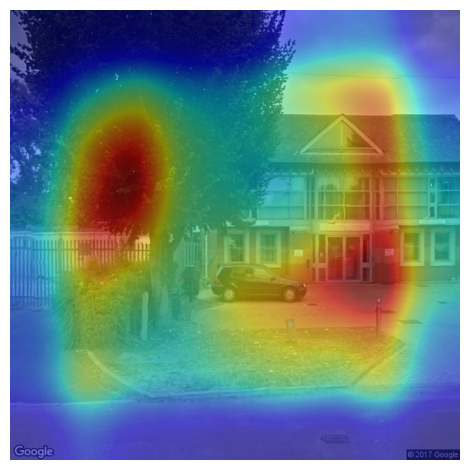

In [44]:
# 或者，如果您希望将其覆盖在输入图像上：

import matplotlib.pyplot as plt
from torchcam.utils import overlay_mask

# Resize the CAM and overlay it
result = overlay_mask(to_pil_image(img), to_pil_image(activation_map[0].cpu().squeeze(0), mode='F'), alpha=0.5)
# Display it
plt.imshow(result); plt.axis('off'); plt.tight_layout(); plt.show()

#### 我们将CAM嵌入评估流程中

In [45]:

test_transform = transforms.Compose([
        transforms.Resize(size=(300, 300), antialias=True), 
        transforms.ToTensor()        
    ])

test_data = CustomDataset(test_data_raw, transform=test_transform)
# 从 DataLoader 中抽取第一批数据

BATCH_SIZE = 8

test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)  # 当您在使用 DataLoader 时设置 num_workers 大于 0 以使用多个子进程加载数据时，PyTorch 使用 multiprocessing 来创建这些子进程。但是，multiprocessing 需要能够从主进程中找到并加载任何自定义函数或类，这在 Jupyter Notebook 或其他交互式环境中可能会出问题。

if __name__ == '__main__': # 以尝试将启动训练过程的代码放入此保护块中。这有助于防止 multiprocessing 在它不应该这样做的时候启动新进程。
    test_data_iter = iter(test_loader)
    test_samples, test_labels, ids = next(test_data_iter) # next() 函数是用来获取迭代器的下一个批次的数据
    print(test_samples.shape, test_labels.shape, len(ids) )


torch.Size([8, 3, 300, 300]) torch.Size([8]) 8



KeyboardInterrupt



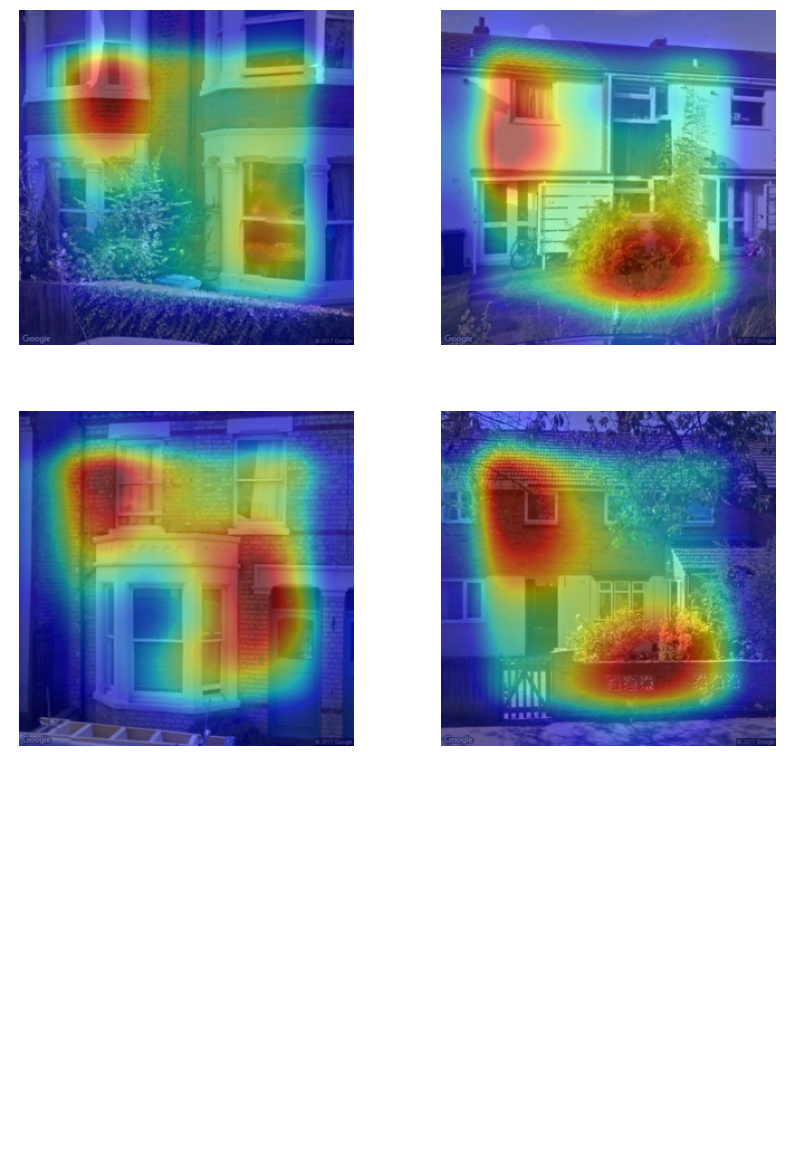

In [46]:
from tqdm import tqdm 
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import numpy as np
from torchcam.methods import SmoothGradCAMpp
from torchvision.transforms.functional import normalize, resize, to_pil_image
from torchcam.utils import overlay_mask

# 设置要显示的图像数量和已处理的图像计数
num_images = 8
images_so_far = 0

# 设置字体和图像显示
fig = plt.figure(figsize=(10, 20))
font = FontProperties(fname=r"C:\Windows\Fonts\simhei.ttf", size=10)


# # 可以继续调用获取第二批数据
next_samples, next_labels, ids = next(test_data_iter)

model.eval()

with SmoothGradCAMpp(model, target_layer='features.denseblock4') as cam_extractor:
        # 将数据移动到GPU上（如果可用）
        images, labels = next_samples.to(device), next_labels.to(device)

        # 运行模型以获取预测（向前传递）
        outputs = model(images)

        # 使用argmax获取最大值的索引
        test_pred_labels = outputs.argmax(dim=1)
        
        # 选择分析CAM
        for j in range(images.size()[0]):
            if images_so_far == num_images:
                break  # 如果我们达到了所需的图像数量，就停止
            
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            
            # 获取原始图像和对应的输出
            img = images[j] # torch.Size([3, 300, 300])
            output = outputs[j] # torch.Size([9])
            # print(img.shape, output.shape)
            
            # 获取CAM并将其应用到原始图像上
            activation_map = cam_extractor(output.squeeze(0).argmax().item(), output)
            # print(" to_pil_image(img):", to_pil_image(img)) # <PIL.Image.Image image mode=RGB size=300x300 at 0x1F3C85FFFD0>
            # print("activation_map:", activation_map) # tensor列表
            # print("activation_map[0]:", activation_map[0].shape) # torch.Size([8, 9, 9])
            # [0, :, :] 选择第一个元素，并丢弃第一个维度
            #print("activation_map[0][0, :, :]：", activation_map[0][0, :, :].shape) # torch.Size([9, 9])
            result = overlay_mask(to_pil_image(img), to_pil_image(activation_map[0][0, :, :].cpu(), mode='F'), alpha=0.5)

            plt.imshow(result)
            

# 调整布局并显示所有图像
plt.tight_layout()
plt.show()

### 9.进行评估


In [47]:
# 读取预测的结果
# 读取标签
import pandas as pd

df = pd.read_csv('predictions_with_building_style_model_2_on_test_data.csv')
df.head()

,id,prediction,true_label
0,1000010019320,4,4
1,1000010136610,3,3
2,1000010145714,3,3
3,1000010178287,5,5
4,1000010062150,4,4


#### 召回率、精确度和F1分数的概念解释
[Part4.对建筑年代进行深度学习结果进行展示和分析(下)——《通过深度学习了解建筑年代和风格》](https://cdn.renhai-lab.tech/archives/Understanding_architecture_age_and_style_through_deep_learning_part4-2)

In [49]:
true_labels = df['true_label'].tolist()
pred_labels = df['prediction'].tolist()

In [50]:
from sklearn.metrics import confusion_matrix, classification_report

# 计算混淆矩阵
conf_matrix = confusion_matrix(true_labels, pred_labels)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[  74    1   18    0    1    1    1]
 [   0  234    1    0    0   40    8]
 [   9    0  430    7   20    7    4]
 [   0    2   12 1291   13   90    3]
 [   1    6   36   28  760   12    5]
 [   0   34    5   58    3 1670   10]
 [   1   17    5    3    4    6  120]]


dict_keys(['18th-century_style', 'contemporary', 'early_19th-century_style', 'interwar', 'late_19th-century_style', 'postwar', 'revival'])

In [57]:
# 借助混淆矩阵计算各种分类指标(召回率、精确度和F1分数)
# 分类报告（classification report）为我们提供了每个类别的主要分类指标的细分，这有助于我们理解模型在预测每个特定类别时的性能
class_names = list(class_dict.keys())
report = classification_report(true_labels, pred_labels, target_names=class_names)

print("\nClassification Report:")
print(report)


Classification Report:
                          precision    recall  f1-score   support

      18th-century_style       0.87      0.77      0.82        96
            contemporary       0.80      0.83      0.81       283
early_19th-century_style       0.85      0.90      0.87       477
                interwar       0.93      0.91      0.92      1411
 late_19th-century_style       0.95      0.90      0.92       848
                 postwar       0.91      0.94      0.93      1780
                 revival       0.79      0.77      0.78       156

                accuracy                           0.91      5051
               macro avg       0.87      0.86      0.87      5051
            weighted avg       0.91      0.91      0.91      5051


### 10.可视化混淆矩阵

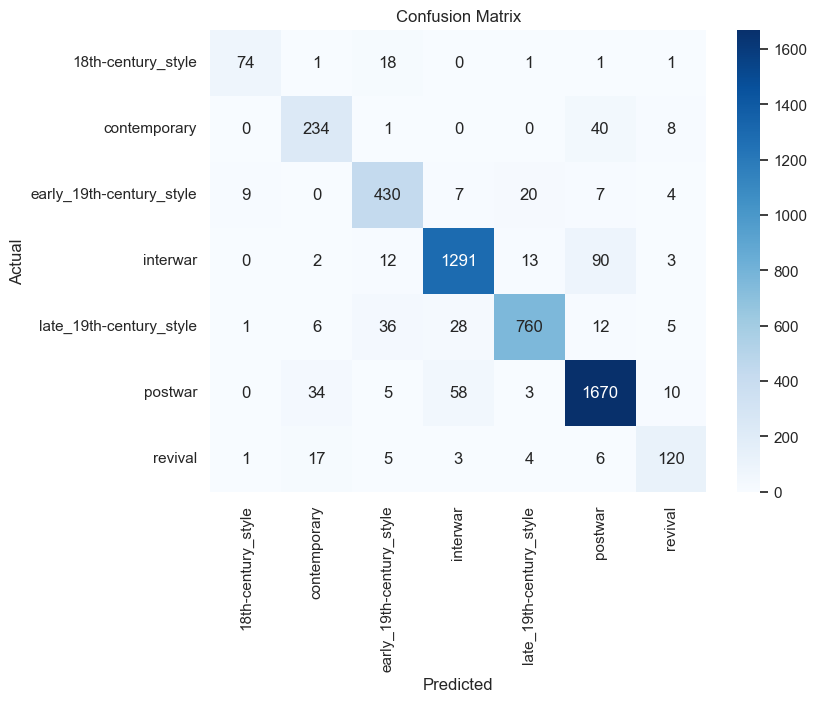

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt

# 设置可视化效果的样式
sns.set(style='whitegrid', palette='muted')

# 将混淆矩阵转换为DataFrame
conf_matrix_df = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)

# 创建热图
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

#### 10 绘制百分比表示的混淆矩阵图
参考论文的Table 3绘制百分比表示的混淆矩阵，要将混淆矩阵中的值转换为百分比形式，您需要计算每个类别的总数（即混淆矩阵中的每一行之和），然后将每个单元格的值除以相应的行总数。这样可以得到每个类别中每个预测的相对频率。

In [59]:
import numpy as np

# 计算每行的总数（每个实际类别的总数）
row_sums = conf_matrix.sum(axis=1)

# 计算百分比：每个单元格除以对应行的总和，然后乘以100
# 使用 np.newaxis 来确保正确的广播
percent_conf_matrix = conf_matrix / row_sums[:, np.newaxis] * 100

# 将混淆矩阵转换为 DataFrame，用于可视化
percent_conf_matrix_df = pd.DataFrame(percent_conf_matrix, index=class_names, columns=class_names)
percent_conf_matrix_df


,18th-century_style,contemporary,early_19th-century_style,interwar,late_19th-century_style,postwar,revival
18th-century_style,77.083333,1.041667,18.750000,0.000000,1.041667,1.041667,1.041667
contemporary,0.000000,82.685512,0.353357,0.000000,0.000000,14.134276,2.826855
early_19th-century_style,1.886792,0.000000,90.146751,1.467505,4.192872,1.467505,0.838574
interwar,0.000000,0.141743,0.850461,91.495393,0.921332,6.378455,0.212615
late_19th-century_style,0.117925,0.707547,4.245283,3.301887,89.622642,1.415094,0.589623
postwar,0.000000,1.910112,0.280899,3.258427,0.168539,93.820225,0.561798
revival,0.641026,10.897436,3.205128,1.923077,2.564103,3.846154,76.923077


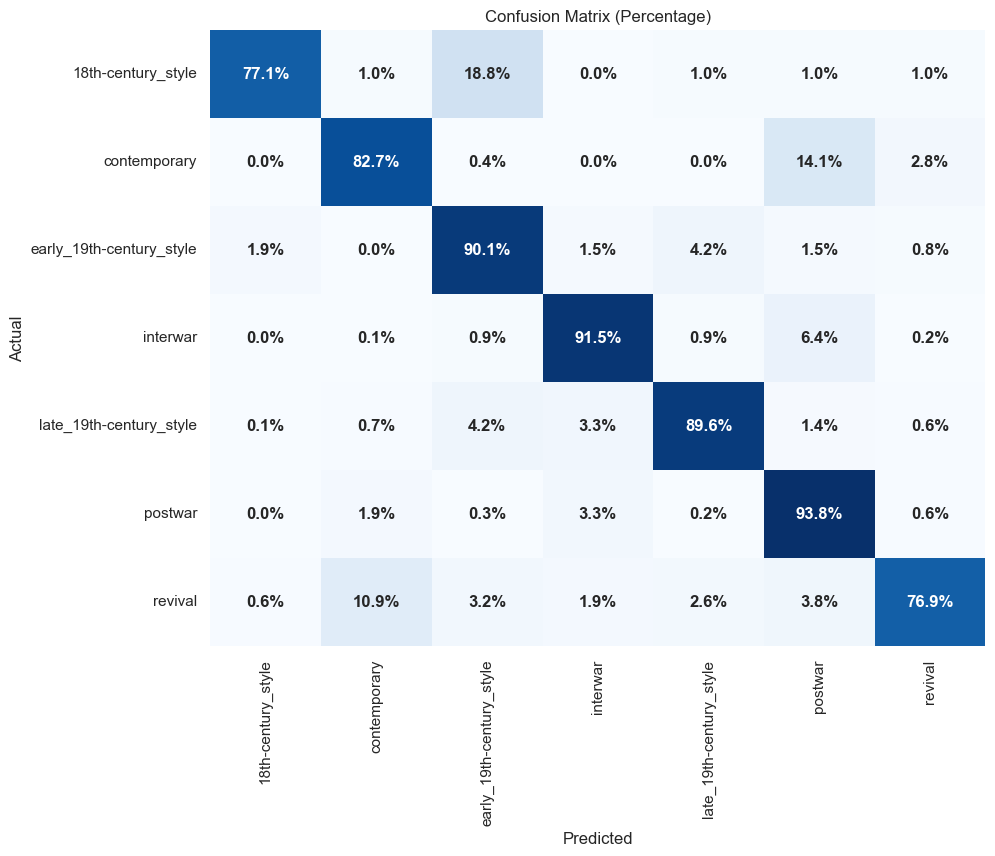

In [60]:
# 创建热图
# 创建一个函数来格式化注释为百分比形式
def format_percentage(val, decimals):
    # 转换为百分比并格式化
    percent_val = "{:.{}f}%".format(val, decimals)
    return percent_val

# 创建百分比形式的混淆矩阵的热图
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(
    percent_conf_matrix_df, 
    annot=True, 
    fmt='.1f',  # 注意：这里仍然保持一位小数的格式，确保数值的精确度
    cmap='Blues', 
    cbar=False,
    annot_kws={"size": 12, "weight": "bold", "ha": "center", "va": "center"},  # 设置注释的字体大小和粗细
)

# 修改每个单元格中的文本注释，使其显示为百分比格式
for text in heatmap.texts:
    text.set_text(format_percentage(float(text.get_text()), 1))
    
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix (Percentage)')
plt.show()


## ## 二、对训练数据集的预测然后绘制整个数据集的混淆矩阵

对训练集的预测和测试集的预测是一样的，只是数据集不一样，所以我们可以直接复用上面的代码，只需要修改数据集即可。


In [22]:
# 读取预测的结果
# 读取标签
import pandas as pd

df1 = pd.read_csv('predictions_with_building_age_model_6_on_test_data.csv')
df2 = pd.read_csv('predictions_with_building_age_model_6_on_train_data.csv')
df = pd.concat([df1, df2])
print(f"数据长度：df1:{len(df1)}\n df2:{len(df2)} \n df:{len(df)}")
true_labels = df['true_label'].tolist()
pred_labels = df['prediction'].tolist()
# original_mapping = class_dict
# original_mapping
# 我们将“pre-1652”的索引从8更改为0，其他类别相应地向后移动
updated_class_dict = {
    0: '–1652',  # 这个现在是第一个
    1: '-1706',
    2: '-1765',
    3: '-1846',
    4: '-1911',
    5: '-1944',
    6: '-1978',
    7: '–1995',
    8: '–2023'  # 这个现在是最后一个
}

# 我们需要更新标签以反映这个新顺序
# 这意味着我们需要将所有的8替换为0，然后将其他所有数字加1（因为我们把'–1652'放在了最前面）
updated_true_labels = [(label + 1 if label < 8 else 0) for label in true_labels]
updated_pred_labels = [(label + 1 if label < 8 else 0) for label in pred_labels]

数据长度：df1:15911
 df2:15911 
 df:31822


In [19]:
from sklearn.metrics import confusion_matrix, classification_report
# 计算混淆矩阵
conf_matrix = confusion_matrix(updated_true_labels, updated_pred_labels)
print("Confusion Matrix:")
print(conf_matrix)

# 借助混淆矩阵计算各种分类指标(召回率、精确度和F1分数)
class_names = list(updated_class_dict.values())
report = classification_report(updated_true_labels, updated_pred_labels, target_names=class_names)

print("\nClassification Report:")
print(report)
### 9.可视化混淆矩阵


Confusion Matrix:
[[  120    34    88    50   102    20     4    22    16]
 [   28   124   100    30    44     6     0     2     4]
 [   70    82   292   104   134     6    12    18    16]
 [   46    28   108   142   134    26     4    26    10]
 [  130    74   150   152  4766   286    40   130    92]
 [   28    12    52    30   590 11840   204   110   110]
 [   16     8    14    16    68   218  3438    76    90]
 [   28     2    34    22   146   108    78  2226   118]
 [   16     4    16    14   118   116    96   106  3782]]

Classification Report:
              precision    recall  f1-score   support

       –1652       0.25      0.26      0.26       456
       -1706       0.34      0.37      0.35       338
       -1765       0.34      0.40      0.37       734
       -1846       0.25      0.27      0.26       524
       -1911       0.78      0.82      0.80      5820
       -1944       0.94      0.91      0.92     12976
       -1978       0.89      0.87      0.88      3944
       –199

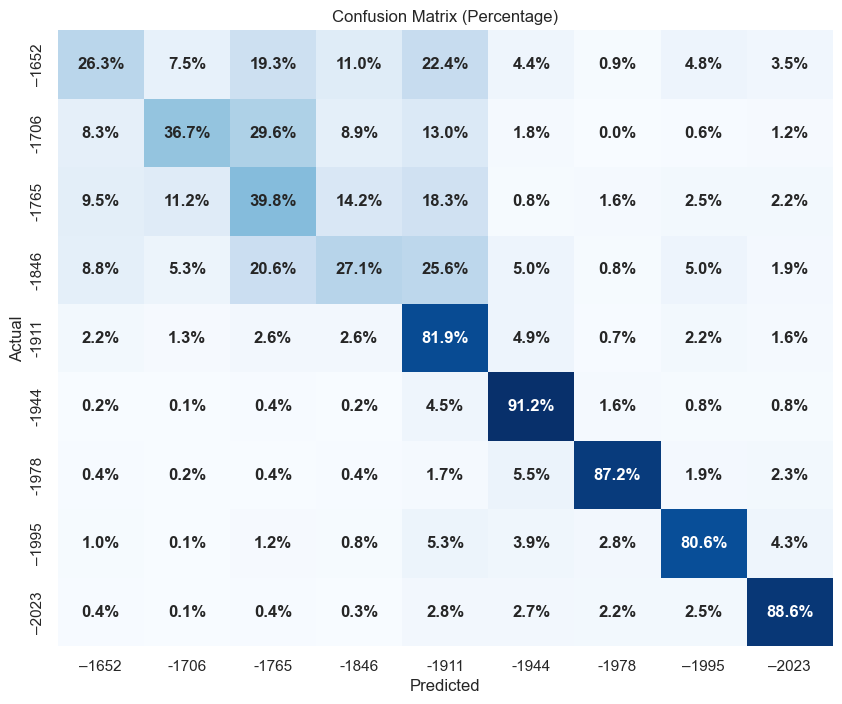

In [20]:
#### 10 绘制百分比表示的混淆矩阵图

import numpy as np

# 计算每行的总数（每个实际类别的总数）
row_sums = conf_matrix.sum(axis=1)

# 计算百分比：每个单元格除以对应行的总和，然后乘以100
# 使用 np.newaxis 来确保正确的广播
percent_conf_matrix = conf_matrix / row_sums[:, np.newaxis] * 100

# 将混淆矩阵转换为 DataFrame，用于可视化
percent_conf_matrix_df = pd.DataFrame(percent_conf_matrix, index=class_names, columns=class_names)

# 创建热图
# 创建一个函数来格式化注释为百分比形式
def format_percentage(val, decimals):
    # 转换为百分比并格式化
    percent_val = "{:.{}f}%".format(val, decimals)
    return percent_val

# 创建百分比形式的混淆矩阵的热图
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(
    percent_conf_matrix_df, 
    annot=True, 
    fmt='.1f',  # 注意：这里仍然保持一位小数的格式，确保数值的精确度
    cmap='Blues', 
    cbar=False,
    annot_kws={"size": 12, "weight": "bold", "ha": "center", "va": "center"},  # 设置注释的字体大小和粗细
)

# 修改每个单元格中的文本注释，使其显示为百分比格式
for text in heatmap.texts:
    text.set_text(format_percentage(float(text.get_text()), 1))
    
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix (Percentage)')
plt.show()